<a href="https://colab.research.google.com/github/tas0931/Music_Clustering_CSE425/blob/main/code%20(src)/hard_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2: Install Required Libraries
!pip install -q sentence-transformers
!pip install -q umap-learn
!pip install -q scikit-learn
!pip install -q librosa
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q torch torchvision

print(" All libraries installed!")

 All libraries installed!


In [ ]:
# Cell 3: Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)

# Visualization
from sklearn.manifold import TSNE
import umap

# Set seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(" All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

 All libraries imported successfully!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


In [ ]:
# Cell 4: Load Audio Features from Medium Task
print("=" * 80)
print("LOADING AUDIO FEATURES")
print("=" * 80)

# Load medium task results
medium_task_path = '/content/drive/MyDrive/cse425 datasets/medium_task_results.pkl'

if os.path.exists(medium_task_path):
    with open(medium_task_path, 'rb') as f:
        medium_results = pickle.load(f)

    print(" Medium task results loaded")
# Fallback: Load from easy task
easy_task_path = '/content/drive/MyDrive/cse425 datasets/vae_clustering_results.pkl'
with open(easy_task_path, 'rb') as f:
      easy_results = pickle.load(f)

X_audio = easy_results['X_scaled']
audio_files = easy_results['audio_files']
print(" Audio features loaded from easy task")

LOADING AUDIO FEATURES
 Medium task results loaded
 Audio features loaded from easy task


In [ ]:
# Cell 5: Load Lyrics Data
print("=" * 80)
print("LOADING LYRICS DATA")
print("=" * 80)

lyrics_csv_path = '/content/drive/MyDrive/cse425 datasets/lyrics_data.csv'
lyrics_df = pd.read_csv(lyrics_csv_path)

print(f" Lyrics loaded!")
print(f"  Total lyrics: {len(lyrics_df)}")
print(f"  Columns: {lyrics_df.columns.tolist()}")
print()
print(lyrics_df.head())

LOADING LYRICS DATA
 Lyrics loaded!
  Total lyrics: 1910
  Columns: ['audio_file', 'folder', 'filename', 'lyrics', 'lyrics_file', 'word_count']

                                          audio_file  folder    filename  \
0  /content/drive/MyDrive/cse425 datasets/FMA_Dat...      50  050272.mp3   
1  /content/drive/MyDrive/cse425 datasets/FMA_Dat...      50  050276.mp3   
2  /content/drive/MyDrive/cse425 datasets/FMA_Dat...      50  050283.mp3   
3  /content/drive/MyDrive/cse425 datasets/FMA_Dat...      50  050444.mp3   
4  /content/drive/MyDrive/cse425 datasets/FMA_Dat...      50  050445.mp3   

                                              lyrics  \
0  Come and catch my soul, boy you're lying, I'm ...   
1  your rules and repairing for the day. When all...   
2  Let's grab the vibes in the rain and ragassant...   
3  것앞음낍laimer is my way whatever i get но quanto ...   
4            Those indần mixed with the exactly same   

                                         lyrics_file  word_co

In [ ]:
# Cell 6: Load Genre Information
print("=" * 80)
print("LOADING GENRE INFORMATION")
print("=" * 80)

# Load FMA metadata
tracks_path = '/content/drive/MyDrive/cse425 datasets/FMA_Dataset/fma_metadata/tracks.csv'
genres_path = '/content/drive/MyDrive/cse425 datasets/FMA_Dataset/fma_metadata/genres.csv' # Changed to genres.csv for genre hierarchy

# FMA tracks.csv has a multi-level header, need special handling
tracks_df = pd.read_csv(tracks_path, header=[0, 1], index_col=0)

# Load genres
genres_df = pd.read_csv(genres_path, index_col=0) # Loaded genres.csv for consistency if other parts use it

print(f" Metadata loaded!")
print(f"  Tracks: {len(tracks_df)}")
print(f"  Genres: {len(genres_df)}")
print()
print("Track metadata columns (first 20 to check genre_top):")
print(tracks_df.columns[:20]) # Check columns of the correct tracks_df
print()
print("Sample genre categories from tracks_df:")
# Try to access the genre_top column directly from the tracks_df now
if ('track', 'genre_top') in tracks_df.columns:
    print(tracks_df[('track', 'genre_top')].value_counts().head(10))

LOADING GENRE INFORMATION
 Metadata loaded!
  Tracks: 106574
  Genres: 163

Track metadata columns (first 20 to check genre_top):
MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('a

In [ ]:
# Cell 7: Extract Genre Information for Our Audio Files
dataset_path = '/content/drive/MyDrive/cse425 datasets/FMA_Dataset'
audio_path = os.path.join(dataset_path, 'fma_small')
print("=" * 80)
print("EXTRACTING GENRE LABELS FOR OUR DATASET")
print("=" * 80)

# Extract track IDs from audio file paths
# Format: .../fma_small/050/050123.mp3 -> track_id = 50123

def extract_track_id(audio_path):
    """Extract track ID from audio file path"""
    filename = os.path.basename(audio_path)
    track_id = int(filename.replace('.mp3', ''))
    return track_id

# Create mapping
audio_track_mapping = []

for audio_file in audio_files:
    try:
        track_id = extract_track_id(audio_file)
        audio_track_mapping.append({
            'audio_file': audio_file,
            'track_id': track_id
        })
    except:
        print(f"Warning: Could not extract track ID from {audio_file}")

audio_track_df = pd.DataFrame(audio_track_mapping)

print(f" Extracted {len(audio_track_df)} track IDs")
print()
print(audio_track_df.head())

EXTRACTING GENRE LABELS FOR OUR DATASET
 Extracted 2294 track IDs

                                          audio_file  track_id
0  /content/drive/MyDrive/cse425 datasets/FMA_Dat...     50283
1  /content/drive/MyDrive/cse425 datasets/FMA_Dat...     50449
2  /content/drive/MyDrive/cse425 datasets/FMA_Dat...     50444
3  /content/drive/MyDrive/cse425 datasets/FMA_Dat...     50754
4  /content/drive/MyDrive/cse425 datasets/FMA_Dat...     50836


In [ ]:
# Cell 8: Match Tracks with Genres
print("=" * 80)
print("MATCHING TRACKS WITH GENRE LABELS")
print("=" * 80)

# The tracks DataFrame has multi-level columns
# Genre information is typically in ('track', 'genre_top') or similar
# Let's explore the structure

print("Tracks DataFrame column structure:")
print(tracks_df.columns[:20])  # Show first 20 columns
print()

# Try to find genre columns
genre_col = None
for col in tracks_df.columns:
    if 'genre' in str(col).lower() and 'top' in str(col).lower():
        genre_col = col
        break

if genre_col:
    print(f" Found genre column: {genre_col}")
else:
    # Fallback - try common column names
    possible_cols = [('track', 'genre_top'), ('track', 'genres'), 'genre_top']
    for col in possible_cols:
        try:
            if col in tracks_df.columns:
                genre_col = col
                print(f"Found genre column: {genre_col}")
                break
        except:
            pass

# Extract genres for our tracks
track_genre_data = []

for idx, row in audio_track_df.iterrows():
    track_id = row['track_id']

    try:
        if track_id in tracks_df.index:
            genre = tracks_df.loc[track_id, genre_col]
            track_genre_data.append({
                'track_id': track_id,
                'audio_file': row['audio_file'],
                'genre': genre
            })
    except Exception as e:
        # Track not found or no genre
        track_genre_data.append({
            'track_id': track_id,
            'audio_file': row['audio_file'],
            'genre': 'Unknown'
        })

track_genre_df = pd.DataFrame(track_genre_data)

# Clean up genres (remove NaN)
track_genre_df['genre'] = track_genre_df['genre'].fillna('Unknown')
track_genre_df = track_genre_df[track_genre_df['genre'] != 'Unknown']

print(f"\n Matched {len(track_genre_df)} tracks with genres")
print(f"Unique genres: {track_genre_df['genre'].nunique()}")
print()
print("Genre distribution:")
print(track_genre_df['genre'].value_counts())

MATCHING TRACKS WITH GENRE LABELS
Tracks DataFrame column structure:
MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites')],
           )

 Found genre col

In [ ]:
# Cell 9: Integrate All Data - Audio, Lyrics, and Genres
print("=" * 80)
print("INTEGRATING ALL DATA SOURCES")
print("=" * 80)

# Merge lyrics with genres
lyrics_df['track_id'] = lyrics_df['audio_file'].apply(extract_track_id)

# Merge everything
integrated_df = lyrics_df.merge(
    track_genre_df[['track_id', 'genre']],
    on='track_id',
    how='inner'
)

print(f" Integration complete!")
print(f"  Total samples with all modalities: {len(integrated_df)}")
print()
print("Sample integrated data:")
print(integrated_df[['filename', 'genre', 'word_count']].head(10))
print()
print("Final genre distribution:")
print(integrated_df['genre'].value_counts())

INTEGRATING ALL DATA SOURCES
 Integration complete!
  Total samples with all modalities: 1910

Sample integrated data:
     filename          genre  word_count
0  050272.mp3            Pop          30
1  050276.mp3           Folk          79
2  050283.mp3  International          36
3  050444.mp3           Rock          11
4  050445.mp3           Rock           7
5  050446.mp3           Rock          14
6  050447.mp3           Rock           6
7  050448.mp3           Rock          11
8  050449.mp3           Rock          63
9  050539.mp3           Rock          11

Final genre distribution:
genre
Hip-Hop          285
Pop              283
Folk             283
Rock             263
Electronic       248
International    240
Experimental     196
Instrumental     112
Name: count, dtype: int64


In [ ]:
# Cell 10: Prepare Features - Audio, Lyrics, and Genre Encodings
print("=" * 80)
print("PREPARING MULTI-MODAL FEATURES")
print("=" * 80)

# Get audio features for matched tracks
matched_audio_features = []
matched_lyrics = []
matched_genres = []
matched_files = []

# Load audio features properly
if 'medium_results' in locals():
    # Use medium task audio features
    audio_features_dict = {}
    for idx, file in enumerate(audio_files):
        audio_features_dict[file] = X_audio[idx]
else:
    # Load from easy task
    audio_features_dict = {}
    for idx, file in enumerate(audio_files):
        audio_features_dict[file] = X_audio[idx]

# Collect matched features
for idx, row in integrated_df.iterrows():
    audio_file = row['audio_file']
    if audio_file in audio_features_dict:
        matched_audio_features.append(audio_features_dict[audio_file])
        matched_lyrics.append(row['lyrics'])
        matched_genres.append(row['genre'])
        matched_files.append(audio_file)

X_audio_matched = np.array(matched_audio_features)

print(f" Matched audio features: {X_audio_matched.shape}")
print(f" Matched lyrics: {len(matched_lyrics)}")
print(f" Matched genres: {len(matched_genres)}")

PREPARING MULTI-MODAL FEATURES
 Matched audio features: (1910, 40)
 Matched lyrics: 1910
 Matched genres: 1910


In [ ]:
# Cell 11: Generate Lyrics Embeddings
print("=" * 80)
print("GENERATING LYRICS EMBEDDINGS")
print("=" * 80)

from sentence_transformers import SentenceTransformer

# Load model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Generating lyrics embeddings...")
X_lyrics_embeddings = embedding_model.encode(
    matched_lyrics,
    show_progress_bar=True,
    batch_size=32,
    convert_to_numpy=True
)

# Normalize
lyrics_scaler = StandardScaler()
X_lyrics_normalized = lyrics_scaler.fit_transform(X_lyrics_embeddings)

print(f"\n Lyrics embeddings: {X_lyrics_normalized.shape}")

GENERATING LYRICS EMBEDDINGS
Generating lyrics embeddings...


Batches:   0%|          | 0/60 [00:00<?, ?it/s]


 Lyrics embeddings: (1910, 384)


In [ ]:
# Cell 12: Encode Genre Information
print("=" * 80)
print("ENCODING GENRE INFORMATION")
print("=" * 80)

# Label encoding (for conditional VAE)
label_encoder = LabelEncoder()
genre_labels = label_encoder.fit_transform(matched_genres)
n_genres = len(label_encoder.classes_)

print(f" Genre labels encoded")
print(f"  Unique genres: {n_genres}")
print(f"  Classes: {label_encoder.classes_}")
print()

# One-hot encoding (for feature concatenation)
onehot_encoder = OneHotEncoder(sparse_output=False)
genre_onehot = onehot_encoder.fit_transform(genre_labels.reshape(-1, 1))

print(f" One-hot encoding: {genre_onehot.shape}")

ENCODING GENRE INFORMATION
 Genre labels encoded
  Unique genres: 8
  Classes: ['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']

 One-hot encoding: (1910, 8)


In [ ]:
# Cell 13: Create Multi-Modal Feature Sets
print("=" * 80)
print("CREATING MULTI-MODAL FEATURE SETS")
print("=" * 80)

# Normalize audio features
audio_scaler = StandardScaler()
X_audio_normalized = audio_scaler.fit_transform(X_audio_matched)

# Feature Set 1: Audio + Lyrics + Genre (concatenated)
X_multimodal = np.concatenate([
    X_audio_normalized,
    X_lyrics_normalized,
    genre_onehot
], axis=1)

# Feature Set 2: Audio + Lyrics (no genre)
X_audio_lyrics = np.concatenate([
    X_audio_normalized,
    X_lyrics_normalized
], axis=1)

print(f" Feature sets created:")
print(f"  Audio only: {X_audio_normalized.shape}")
print(f"  Lyrics only: {X_lyrics_normalized.shape}")
print(f"  Genre encoding: {genre_onehot.shape}")
print(f"  Audio + Lyrics: {X_audio_lyrics.shape}")
print(f"  Audio + Lyrics + Genre: {X_multimodal.shape}")

CREATING MULTI-MODAL FEATURE SETS
 Feature sets created:
  Audio only: (1910, 40)
  Lyrics only: (1910, 384)
  Genre encoding: (1910, 8)
  Audio + Lyrics: (1910, 424)
  Audio + Lyrics + Genre: (1910, 432)


In [ ]:
# Cell 14: Define Beta-VAE Architecture
class BetaVAE(nn.Module):
    """
    Beta-VAE for disentangled latent representations
    Beta controls the weight of KL divergence term
    """
    def __init__(self, input_dim, latent_dim=32, hidden_dims=[512, 256, 128], beta=4.0):
        super(BetaVAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.beta = beta

        # Encoder
        encoder_layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim

        self.encoder = nn.Sequential(*encoder_layers)

        # Latent space
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder
        decoder_layers = []
        decoder_dims = [latent_dim] + hidden_dims[::-1] + [input_dim]

        for i in range(len(decoder_dims) - 1):
            decoder_layers.append(nn.Linear(decoder_dims[i], decoder_dims[i+1]))
            if i < len(decoder_dims) - 2:
                decoder_layers.extend([
                    nn.BatchNorm1d(decoder_dims[i+1]),
                    nn.ReLU(),
                    nn.Dropout(0.2)
                ])

        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

def beta_vae_loss(recon_x, x, mu, logvar, beta=4.0):
    """
    Beta-VAE loss with adjustable beta parameter
    Higher beta encourages more disentanglement
    """
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Beta-weighted total loss
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

print(" Beta-VAE architecture defined")

 Beta-VAE architecture defined


In [ ]:
# Cell 15: Define Conditional VAE (CVAE) Architecture
class ConditionalVAE(nn.Module):
    """
    Conditional VAE that conditions on genre labels
    Allows generation and encoding conditional on genre
    """
    def __init__(self, input_dim, condition_dim, latent_dim=32, hidden_dims=[512, 256, 128]):
        super(ConditionalVAE, self).__init__()

        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.latent_dim = latent_dim

        # Encoder: takes input + condition
        encoder_input_dim = input_dim + condition_dim
        encoder_layers = []
        prev_dim = encoder_input_dim

        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim

        self.encoder = nn.Sequential(*encoder_layers)

        # Latent space
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder: takes latent + condition
        decoder_input_dim = latent_dim + condition_dim
        decoder_layers = []
        decoder_dims = [decoder_input_dim] + hidden_dims[::-1] + [input_dim]

        for i in range(len(decoder_dims) - 1):
            decoder_layers.append(nn.Linear(decoder_dims[i], decoder_dims[i+1]))
            if i < len(decoder_dims) - 2:
                decoder_layers.extend([
                    nn.BatchNorm1d(decoder_dims[i+1]),
                    nn.ReLU(),
                    nn.Dropout(0.2)
                ])

        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x, c):
        # Concatenate input with condition
        xc = torch.cat([x, c], dim=1)
        h = self.encoder(xc)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        # Concatenate latent with condition
        zc = torch.cat([z, c], dim=1)
        return self.decoder(zc)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar

def cvae_loss(recon_x, x, mu, logvar, beta=1.0):
    """CVAE loss function"""
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

print(" Conditional VAE (CVAE) architecture defined")

 Conditional VAE (CVAE) architecture defined


In [ ]:
# Cell 16: Create PyTorch Datasets
class MultiModalDataset(Dataset):
    """Dataset for multi-modal features"""
    def __init__(self, features):
        self.features = torch.FloatTensor(features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]

class ConditionalDataset(Dataset):
    """Dataset for conditional VAE with genre labels"""
    def __init__(self, features, conditions):
        self.features = torch.FloatTensor(features)
        self.conditions = torch.FloatTensor(conditions)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.conditions[idx]

# Create datasets
dataset_multimodal = MultiModalDataset(X_multimodal)
dataset_audio_lyrics = MultiModalDataset(X_audio_lyrics)
dataset_conditional = ConditionalDataset(X_audio_lyrics, genre_onehot)

# DataLoaders
batch_size = 32
dataloader_multimodal = DataLoader(dataset_multimodal, batch_size=batch_size, shuffle=True)
dataloader_audio_lyrics = DataLoader(dataset_audio_lyrics, batch_size=batch_size, shuffle=True)
dataloader_conditional = DataLoader(dataset_conditional, batch_size=batch_size, shuffle=True)

print(" Datasets and DataLoaders created")
print(f"  Batch size: {batch_size}")
print(f"  Multimodal batches: {len(dataloader_multimodal)}")
print(f"  Conditional batches: {len(dataloader_conditional)}")

 Datasets and DataLoaders created
  Batch size: 32
  Multimodal batches: 60
  Conditional batches: 60


In [ ]:
# Cell 17: Train Beta-VAE on Multi-Modal Features
print("=" * 80)
print("TRAINING BETA-VAE (β=4.0)")
print("=" * 80)

latent_dim = 32
beta_value = 4.0

beta_vae = BetaVAE(
    input_dim=X_multimodal.shape[1],
    latent_dim=latent_dim,
    hidden_dims=[512, 256, 128],
    beta=beta_value
).to(device)

optimizer_beta = optim.Adam(beta_vae.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 150
train_losses_beta = []
recon_losses_beta = []
kl_losses_beta = []

print(f"Model parameters: {sum(p.numel() for p in beta_vae.parameters()):,}")
print()

for epoch in range(num_epochs):
    beta_vae.train()
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    for batch_idx, data in enumerate(dataloader_multimodal):
        data = data.to(device)

        # Forward pass
        recon_batch, mu, logvar = beta_vae(data)
        loss, recon_loss, kl_loss = beta_vae_loss(recon_batch, data, mu, logvar, beta=beta_value)

        # Backward pass
        optimizer_beta.zero_grad()
        loss.backward()
        optimizer_beta.step()

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()

    avg_loss = epoch_loss / len(dataset_multimodal)
    avg_recon = epoch_recon / len(dataset_multimodal)
    avg_kl = epoch_kl / len(dataset_multimodal)

    train_losses_beta.append(avg_loss)
    recon_losses_beta.append(avg_recon)
    kl_losses_beta.append(avg_kl)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}")

print("\n Beta-VAE training complete!")

TRAINING BETA-VAE (β=4.0)
Model parameters: 788,208

Epoch [20/150] - Loss: 394.9226, Recon: 379.5307, KL: 3.8480
Epoch [40/150] - Loss: 383.7593, Recon: 366.1824, KL: 4.3942
Epoch [60/150] - Loss: 378.7968, Recon: 359.5053, KL: 4.8229
Epoch [80/150] - Loss: 376.3208, Recon: 355.4629, KL: 5.2145
Epoch [100/150] - Loss: 373.1445, Recon: 351.1448, KL: 5.4999
Epoch [120/150] - Loss: 370.6843, Recon: 348.3248, KL: 5.5899
Epoch [140/150] - Loss: 369.8119, Recon: 346.6199, KL: 5.7980

 Beta-VAE training complete!


In [ ]:
# Cell 18: Train Conditional VAE
print("=" * 80)
print("TRAINING CONDITIONAL VAE (CVAE)")
print("=" * 80)

cvae = ConditionalVAE(
    input_dim=X_audio_lyrics.shape[1],
    condition_dim=n_genres,
    latent_dim=latent_dim,
    hidden_dims=[512, 256, 128]
).to(device)

optimizer_cvae = optim.Adam(cvae.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses_cvae = []
recon_losses_cvae = []
kl_losses_cvae = []

print(f"Model parameters: {sum(p.numel() for p in cvae.parameters()):,}")
print()

for epoch in range(num_epochs):
    cvae.train()
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    for batch_idx, (data, condition) in enumerate(dataloader_conditional):
        data = data.to(device)
        condition = condition.to(device)

        # Forward pass
        recon_batch, mu, logvar = cvae(data, condition)
        loss, recon_loss, kl_loss = cvae_loss(recon_batch, data, mu, logvar, beta=1.0)

        # Backward pass
        optimizer_cvae.zero_grad()
        loss.backward()
        optimizer_cvae.step()

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()

    avg_loss = epoch_loss / len(dataset_conditional)
    avg_recon = epoch_recon / len(dataset_conditional)
    avg_kl = epoch_kl / len(dataset_conditional)

    train_losses_cvae.append(avg_loss)
    recon_losses_cvae.append(avg_recon)
    kl_losses_cvae.append(avg_kl)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}")

print("\n CVAE training complete!")

TRAINING CONDITIONAL VAE (CVAE)
Model parameters: 785,128

Epoch [20/150] - Loss: 364.8953, Recon: 352.1634, KL: 12.7319
Epoch [40/150] - Loss: 347.3026, Recon: 334.4227, KL: 12.8799
Epoch [60/150] - Loss: 337.4525, Recon: 323.8503, KL: 13.6022
Epoch [80/150] - Loss: 331.0853, Recon: 316.8379, KL: 14.2474
Epoch [100/150] - Loss: 326.5521, Recon: 311.8151, KL: 14.7370
Epoch [120/150] - Loss: 322.8639, Recon: 307.9773, KL: 14.8866
Epoch [140/150] - Loss: 320.4076, Recon: 305.1506, KL: 15.2570

 CVAE training complete!


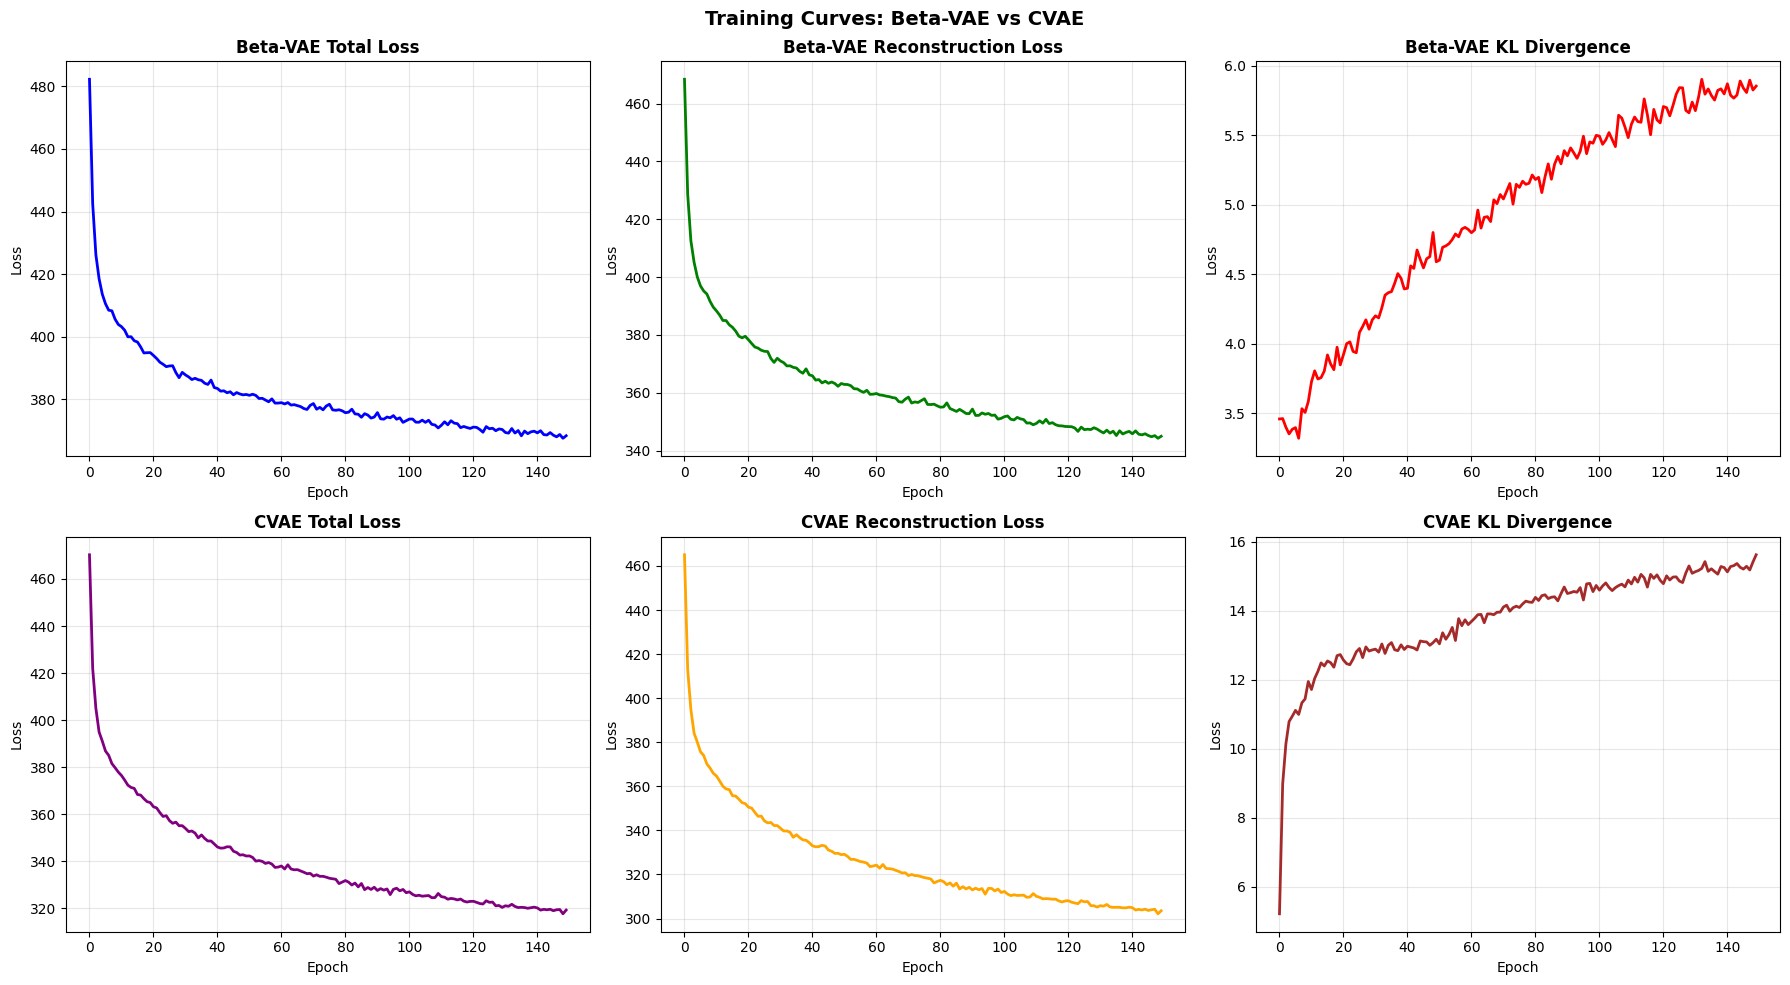

In [ ]:
# Cell 19: Visualize Training Curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Beta-VAE
axes[0, 0].plot(train_losses_beta, linewidth=2, color='blue')
axes[0, 0].set_title('Beta-VAE Total Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(recon_losses_beta, linewidth=2, color='green')
axes[0, 1].set_title('Beta-VAE Reconstruction Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(alpha=0.3)

axes[0, 2].plot(kl_losses_beta, linewidth=2, color='red')
axes[0, 2].set_title('Beta-VAE KL Divergence', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(alpha=0.3)

# CVAE
axes[1, 0].plot(train_losses_cvae, linewidth=2, color='purple')
axes[1, 0].set_title('CVAE Total Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(recon_losses_cvae, linewidth=2, color='orange')
axes[1, 1].set_title('CVAE Reconstruction Loss', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].grid(alpha=0.3)

axes[1, 2].plot(kl_losses_cvae, linewidth=2, color='brown')
axes[1, 2].set_title('CVAE KL Divergence', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].grid(alpha=0.3)

plt.suptitle('Training Curves: Beta-VAE vs CVAE', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cse425 datasets/hard_task_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 20: Extract Latent Features from All Models
print("=" * 80)
print("EXTRACTING LATENT FEATURES")
print("=" * 80)

# Beta-VAE latent features
beta_vae.eval()
Z_beta_vae = []

with torch.no_grad():
    for data in dataloader_multimodal:
        data = data.to(device)
        mu, _ = beta_vae.encode(data)
        Z_beta_vae.append(mu.cpu().numpy())

Z_beta_vae = np.vstack(Z_beta_vae)

# CVAE latent features
cvae.eval()
Z_cvae = []

with torch.no_grad():
    for data, condition in dataloader_conditional:
        data = data.to(device)
        condition = condition.to(device)
        mu, _ = cvae.encode(data, condition)
        Z_cvae.append(mu.cpu().numpy())

Z_cvae = np.vstack(Z_cvae)

print(f" Latent features extracted")
print(f"  Beta-VAE: {Z_beta_vae.shape}")
print(f"  CVAE: {Z_cvae.shape}")

EXTRACTING LATENT FEATURES
 Latent features extracted
  Beta-VAE: (1910, 32)
  CVAE: (1910, 32)


In [ ]:
# Cell 21: Create Baseline Feature Representations
print("=" * 80)
print("CREATING BASELINE METHODS")
print("=" * 80)

# 1. PCA + K-Means
pca_multimodal = PCA(n_components=latent_dim)
Z_pca_multimodal = pca_multimodal.fit_transform(X_multimodal)

print(f" PCA features: {Z_pca_multimodal.shape}")
print(f"  Explained variance: {pca_multimodal.explained_variance_ratio_.sum():.4f}")

# 2. Standard Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32, hidden_dims=[512, 256, 128]):
        super(Autoencoder, self).__init__()

        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        decoder_dims = [latent_dim] + hidden_dims[::-1] + [input_dim]
        for i in range(len(decoder_dims) - 1):
            decoder_layers.append(nn.Linear(decoder_dims[i], decoder_dims[i+1]))
            if i < len(decoder_dims) - 2:
                decoder_layers.append(nn.ReLU())
                decoder_layers.append(nn.Dropout(0.2))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)
        return recon_x, z

# Train Autoencoder
print("\nTraining standard Autoencoder...")
autoencoder = Autoencoder(X_multimodal.shape[1], latent_dim).to(device)
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=1e-3)

for epoch in range(100):
    autoencoder.train()
    epoch_loss = 0

    for data in dataloader_multimodal:
        data = data.to(device)
        recon, z = autoencoder(data)
        loss = F.mse_loss(recon, data)

        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 20 == 0:
        print(f"  Epoch [{epoch+1}/100], Loss: {epoch_loss/len(dataset_multimodal):.4f}")

# Extract AE features
autoencoder.eval()
Z_autoencoder = []
with torch.no_grad():
    for data in dataloader_multimodal:
        data = data.to(device)
        _, z = autoencoder(data)
        Z_autoencoder.append(z.cpu().numpy())
Z_autoencoder = np.vstack(Z_autoencoder)

print(f"\n Autoencoder features: {Z_autoencoder.shape}")

# 3. Direct spectral features (using raw audio features)
Z_spectral = X_audio_normalized

print(f" Direct spectral features: {Z_spectral.shape}")

CREATING BASELINE METHODS
 PCA features: (1910, 32)
  Explained variance: 0.3941

Training standard Autoencoder...
  Epoch [20/100], Loss: 0.0244
  Epoch [40/100], Loss: 0.0231
  Epoch [60/100], Loss: 0.0222
  Epoch [80/100], Loss: 0.0217
  Epoch [100/100], Loss: 0.0211

 Autoencoder features: (1910, 32)
 Direct spectral features: (1910, 40)


In [ ]:
# Cell 22: Apply Clustering to All Feature Representations
print("=" * 80)
print("APPLYING CLUSTERING TO ALL METHODS")
print("=" * 80)

# Define clustering function
def apply_clustering_method(features, method='kmeans', n_clusters=None):
    """Apply clustering with automatic parameter tuning"""
    if method == 'kmeans':
        if n_clusters is None:
            n_clusters = n_genres  # Use number of genres as default
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = clusterer.fit_predict(features)

    elif method == 'agglomerative':
        if n_clusters is None:
            n_clusters = n_genres
        clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        labels = clusterer.fit_predict(features)

    elif method == 'dbscan':
        from sklearn.neighbors import NearestNeighbors
        neighbors = NearestNeighbors(n_neighbors=5)
        neighbors.fit(features)
        distances, _ = neighbors.kneighbors(features)
        eps = np.mean(distances[:, -1])

        clusterer = DBSCAN(eps=eps, min_samples=5)
        labels = clusterer.fit_predict(features)

    return labels

# Feature sets to evaluate
feature_sets = {
    'Beta-VAE': Z_beta_vae,
    'CVAE': Z_cvae,
    'PCA': Z_pca_multimodal,
    'Autoencoder': Z_autoencoder,
    'Spectral': Z_spectral
}

# Clustering methods
clustering_methods = ['kmeans', 'agglomerative']

# Store results
all_clustering_results = {}

for feature_name, features in feature_sets.items():
    print(f"\nClustering: {feature_name}")
    all_clustering_results[feature_name] = {}

    for method in clustering_methods:
        print(f"  - {method.upper()}...", end=' ')
        labels = apply_clustering_method(features, method=method, n_clusters=n_genres)
        all_clustering_results[feature_name][method] = labels
        print(f"Done! ({len(np.unique(labels))} clusters)")

print("\nAll clustering complete")

APPLYING CLUSTERING TO ALL METHODS

Clustering: Beta-VAE
  - KMEANS... Done! (8 clusters)
  - AGGLOMERATIVE... Done! (8 clusters)

Clustering: CVAE
  - KMEANS... Done! (8 clusters)
  - AGGLOMERATIVE... Done! (8 clusters)

Clustering: PCA
  - KMEANS... Done! (8 clusters)
  - AGGLOMERATIVE... Done! (8 clusters)

Clustering: Autoencoder
  - KMEANS... Done! (8 clusters)
  - AGGLOMERATIVE... Done! (8 clusters)

Clustering: Spectral
  - KMEANS... Done! (8 clusters)
  - AGGLOMERATIVE... Done! (8 clusters)

All clustering complete


In [ ]:
# Cell 23: Calculate ALL Evaluation Metrics
print("=" * 80)
print("CALCULATING EVALUATION METRICS")
print("=" * 80)

def calculate_cluster_purity(labels_true, labels_pred):
    """Calculate cluster purity"""
    # Remove noise points if any
    mask = labels_pred >= 0
    labels_true_filtered = np.array(labels_true)[mask]
    labels_pred_filtered = labels_pred[mask]

    if len(labels_pred_filtered) == 0:
        return 0.0

    total_correct = 0
    for cluster_id in np.unique(labels_pred_filtered):
        cluster_mask = labels_pred_filtered == cluster_id
        cluster_true_labels = labels_true_filtered[cluster_mask]

        if len(cluster_true_labels) > 0:
            # Find most common true label in this cluster
            most_common = np.bincount(cluster_true_labels).argmax()
            total_correct += np.sum(cluster_true_labels == most_common)

    purity = total_correct / len(labels_pred_filtered)
    return purity

# Calculate metrics for all combinations
evaluation_results = []

for feature_name, features in feature_sets.items():
    for method in clustering_methods:
        labels_pred = all_clustering_results[feature_name][method]

        # Filter valid clusters
        mask = labels_pred >= 0
        features_filtered = features[mask]
        labels_pred_filtered = labels_pred[mask]
        labels_true_filtered = genre_labels[mask]

        n_clusters_found = len(np.unique(labels_pred_filtered))

        if n_clusters_found > 1 and len(labels_pred_filtered) > 10:
            # Silhouette Score
            try:
                silhouette = silhouette_score(features_filtered, labels_pred_filtered)
            except:
                silhouette = np.nan

            # Davies-Bouldin Index
            try:
                davies_bouldin = davies_bouldin_score(features_filtered, labels_pred_filtered)
            except:
                davies_bouldin = np.nan

            # Calinski-Harabasz Index
            try:
                calinski = calinski_harabasz_score(features_filtered, labels_pred_filtered)
            except:
                calinski = np.nan

            # Normalized Mutual Information (NMI)
            try:
                nmi = normalized_mutual_info_score(labels_true_filtered, labels_pred_filtered)
            except:
                nmi = np.nan

            # Adjusted Rand Index (ARI)
            try:
                ari = adjusted_rand_score(labels_true_filtered, labels_pred_filtered)
            except:
                ari = np.nan

            # Cluster Purity
            try:
                purity = calculate_cluster_purity(labels_true_filtered, labels_pred_filtered)
            except:
                purity = np.nan
        else:
            silhouette = davies_bouldin = calinski = nmi = ari = purity = np.nan

        evaluation_results.append({
            'Feature Type': feature_name,
            'Method': method.upper(),
            'N Clusters': n_clusters_found,
            'Silhouette': silhouette,
            'Davies-Bouldin': davies_bouldin,
            'Calinski-Harabasz': calinski,
            'NMI': nmi,
            'ARI': ari,
            'Purity': purity
        })

# Create DataFrame
results_df = pd.DataFrame(evaluation_results)

print("\nEVALUATION RESULTS:")
print("=" * 80)
print(results_df.to_string(index=False))

CALCULATING EVALUATION METRICS

EVALUATION RESULTS:
Feature Type        Method  N Clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz      NMI       ARI   Purity
    Beta-VAE        KMEANS           8    0.186126        1.460662         289.403687 0.005334 -0.000556 0.182199
    Beta-VAE AGGLOMERATIVE           8    0.123588        1.657228         235.071228 0.006404  0.000215 0.171204
        CVAE        KMEANS           8    0.104482        2.050212         137.854202 0.007038  0.000407 0.174346
        CVAE AGGLOMERATIVE           8    0.057988        2.487295         103.711243 0.007953  0.000075 0.175393
         PCA        KMEANS           8    0.088948        2.512750         109.298128 0.108790  0.078193 0.315183
         PCA AGGLOMERATIVE           8    0.055851        3.196150          88.753232 0.076006  0.045393 0.270681
 Autoencoder        KMEANS           8    0.161990        1.934012         142.012039 0.006487 -0.001797 0.163874
 Autoencoder AGGLOMERATIVE          

In [ ]:
# Cell 24: Save metrics to CSV
results_df.to_csv('/content/drive/MyDrive/cse425 datasets/hard_task_metrics.csv', index=False)
print("\n Metrics saved to CSV")


 Metrics saved to CSV


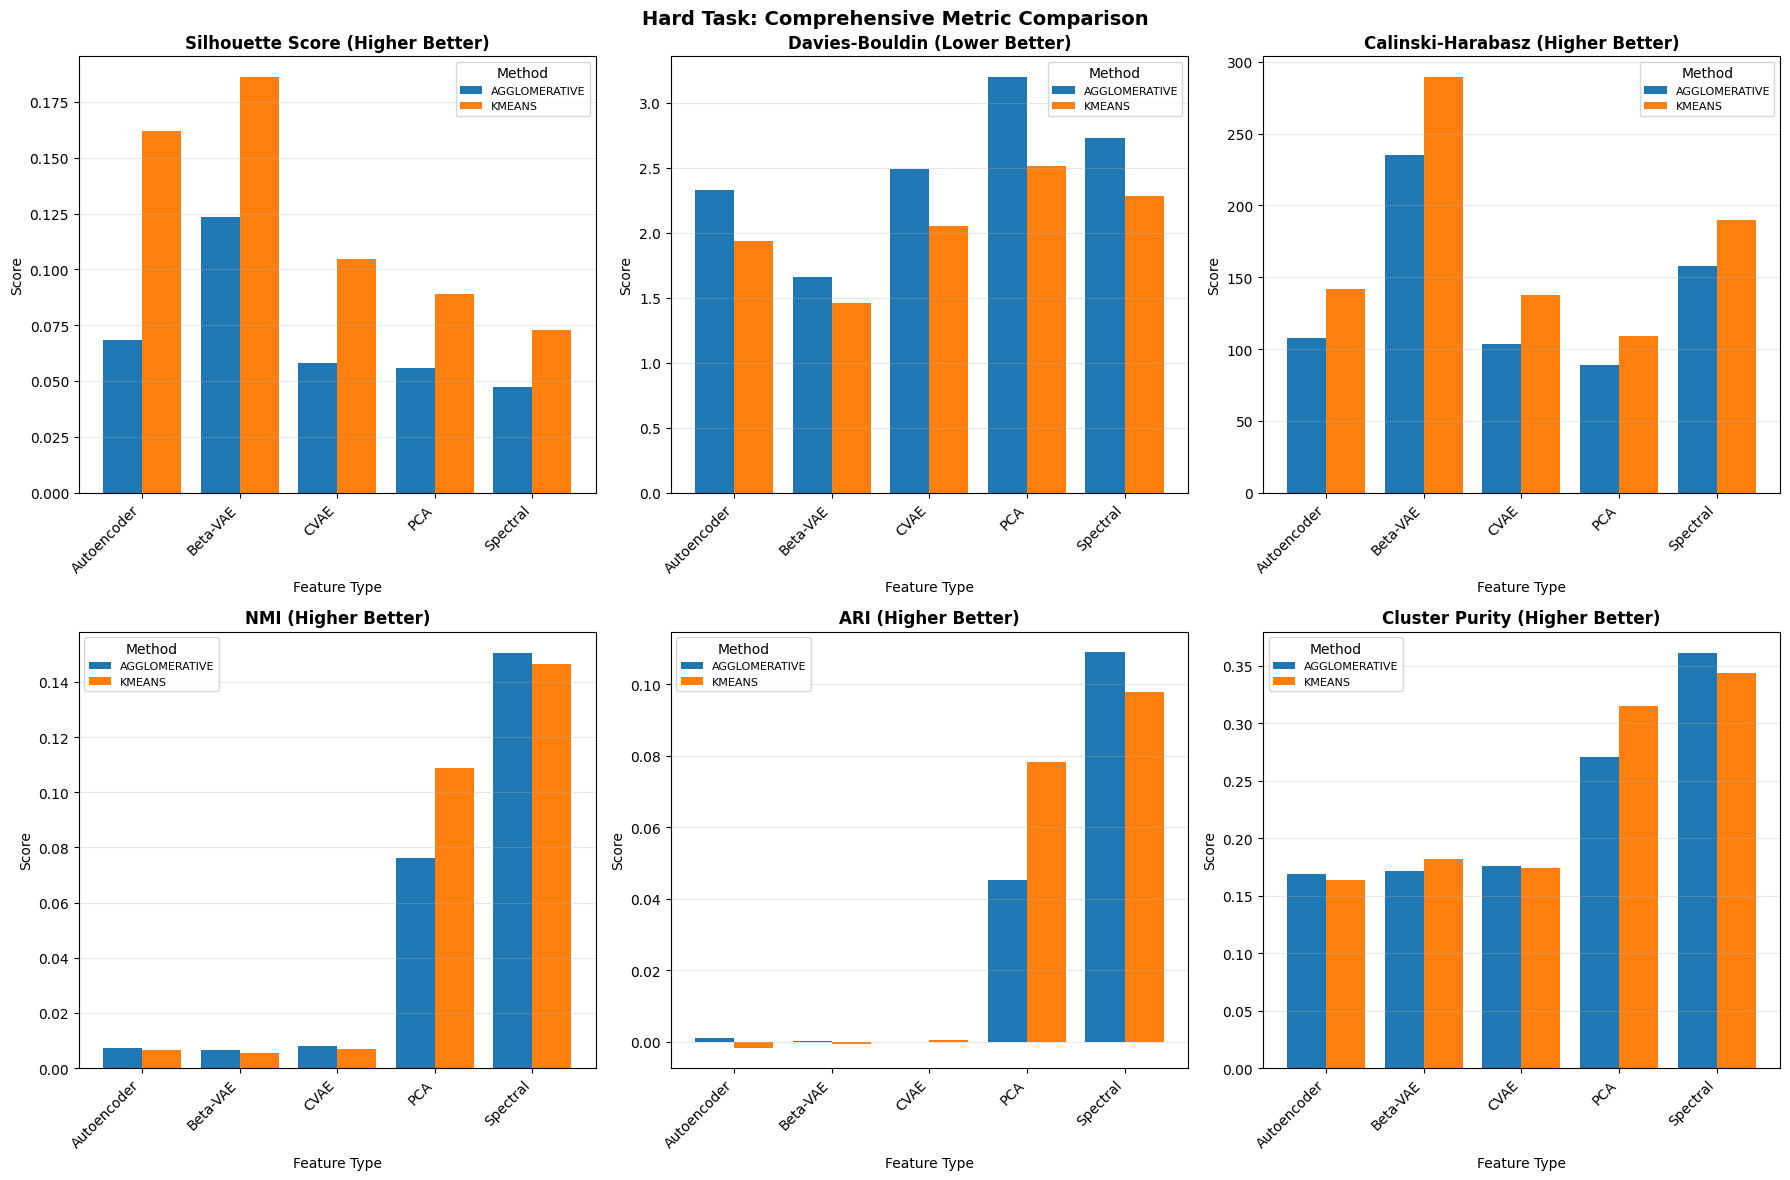

In [ ]:
# Cell 25: Visualize Metric Comparisons
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz', 'NMI', 'ARI', 'Purity']
titles = [
    'Silhouette Score (Higher Better)',
    'Davies-Bouldin (Lower Better)',
    'Calinski-Harabasz (Higher Better)',
    'NMI (Higher Better)',
    'ARI (Higher Better)',
    'Cluster Purity (Higher Better)'
]

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 3, idx % 3]

    pivot = results_df.pivot(index='Feature Type', columns='Method', values=metric)
    pivot.plot(kind='bar', ax=ax, width=0.8)

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Score')
    ax.legend(title='Method', fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Hard Task: Comprehensive Metric Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cse425 datasets/hard_task_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

CREATING t-SNE VISUALIZATIONS
Computing t-SNE for Beta-VAE... Done!
Computing t-SNE for CVAE... Done!
Computing t-SNE for PCA... Done!
Computing t-SNE for Autoencoder... Done!
Computing t-SNE for Spectral... Done!


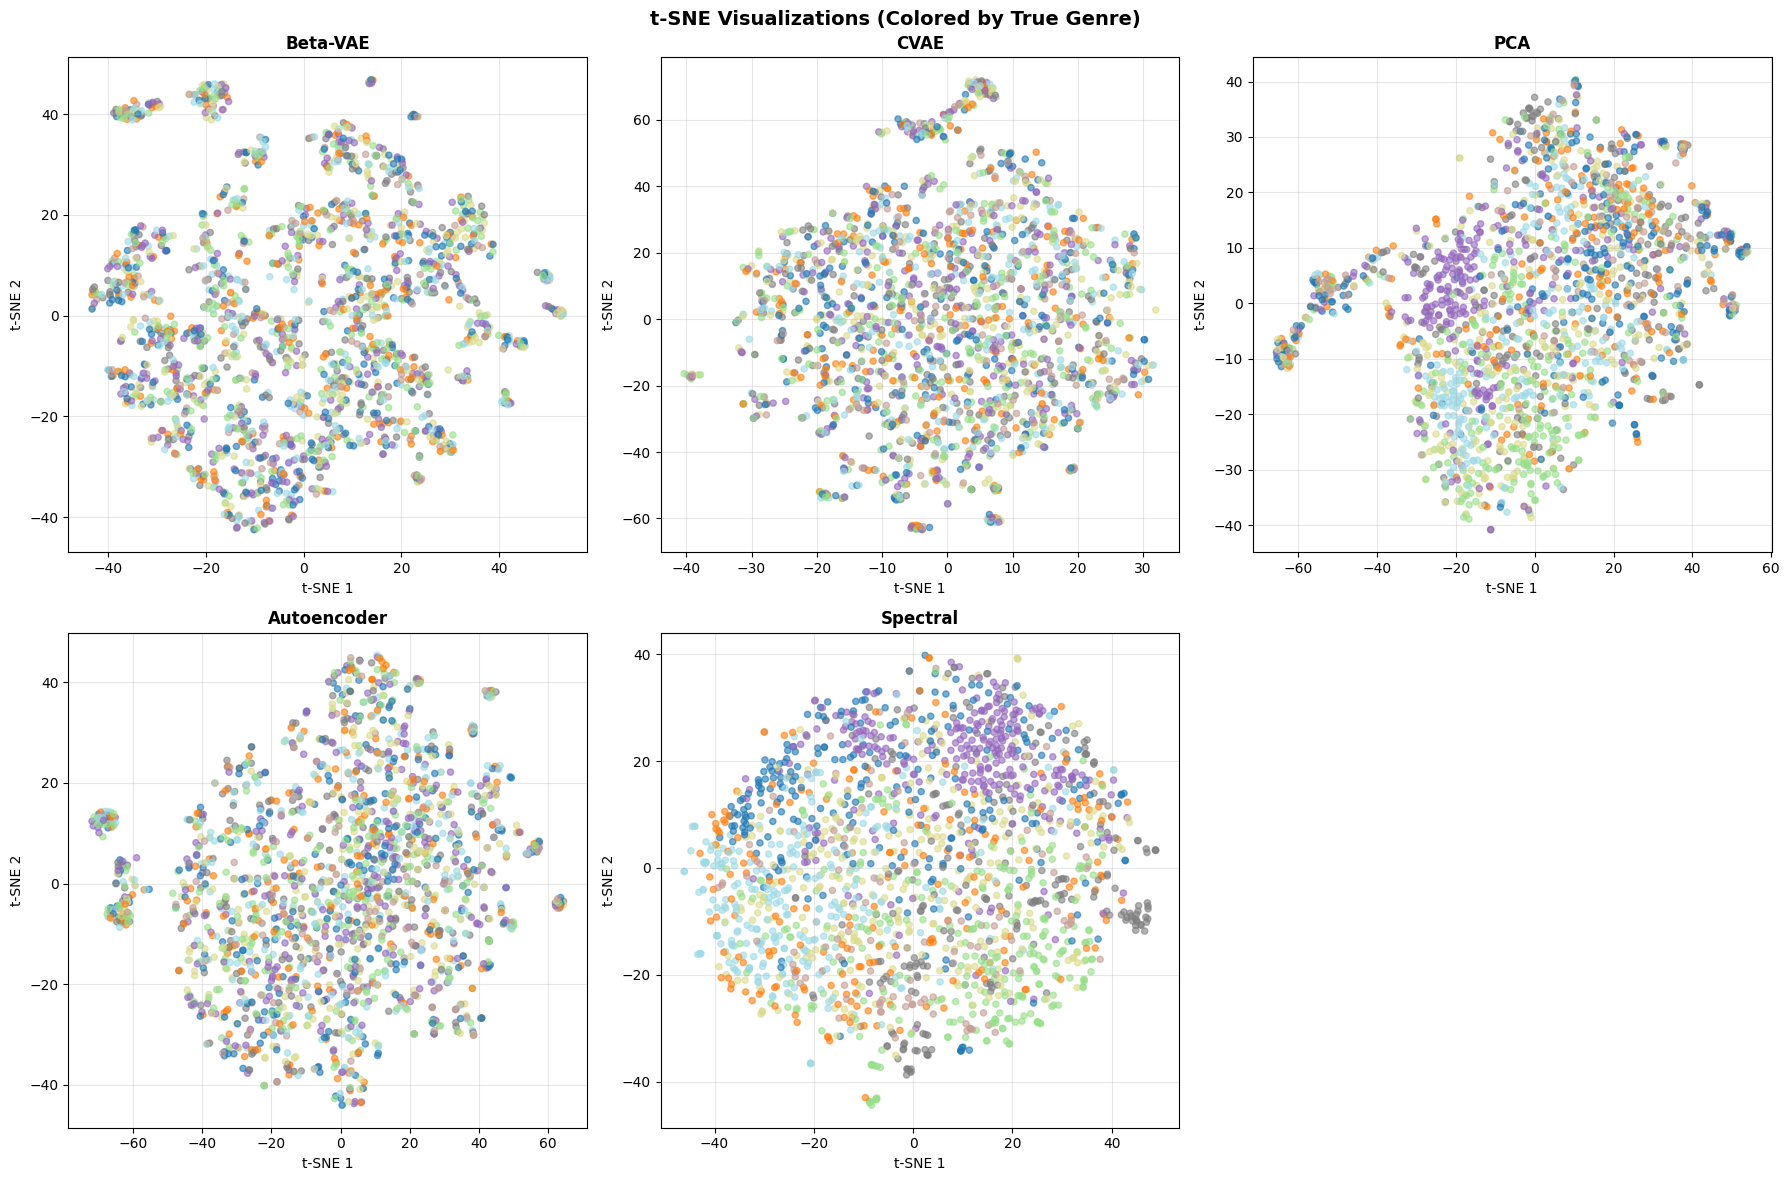

In [ ]:
# Cell 26: t-SNE Visualization of All Methods
print("=" * 80)
print("CREATING t-SNE VISUALIZATIONS")
print("=" * 80)

tsne_projections = {}

for feature_name, features in feature_sets.items():
    print(f"Computing t-SNE for {feature_name}...", end=' ')
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_projections[feature_name] = tsne.fit_transform(features)
    print("Done!")

# Plot t-SNE with genre colors
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (feature_name, projection) in enumerate(tsne_projections.items()):
    if idx < len(axes):
        scatter = axes[idx].scatter(
            projection[:, 0],
            projection[:, 1],
            c=genre_labels,
            cmap='tab20',
            s=20,
            alpha=0.6
        )
        axes[idx].set_title(f'{feature_name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('t-SNE 1')
        axes[idx].set_ylabel('t-SNE 2')
        axes[idx].grid(alpha=0.3)

# Hide unused subplot
if len(feature_sets) < len(axes):
    axes[-1].axis('off')

plt.suptitle('t-SNE Visualizations (Colored by True Genre)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cse425 datasets/hard_task_tsne_genres.png', dpi=300, bbox_inches='tight')
plt.show()

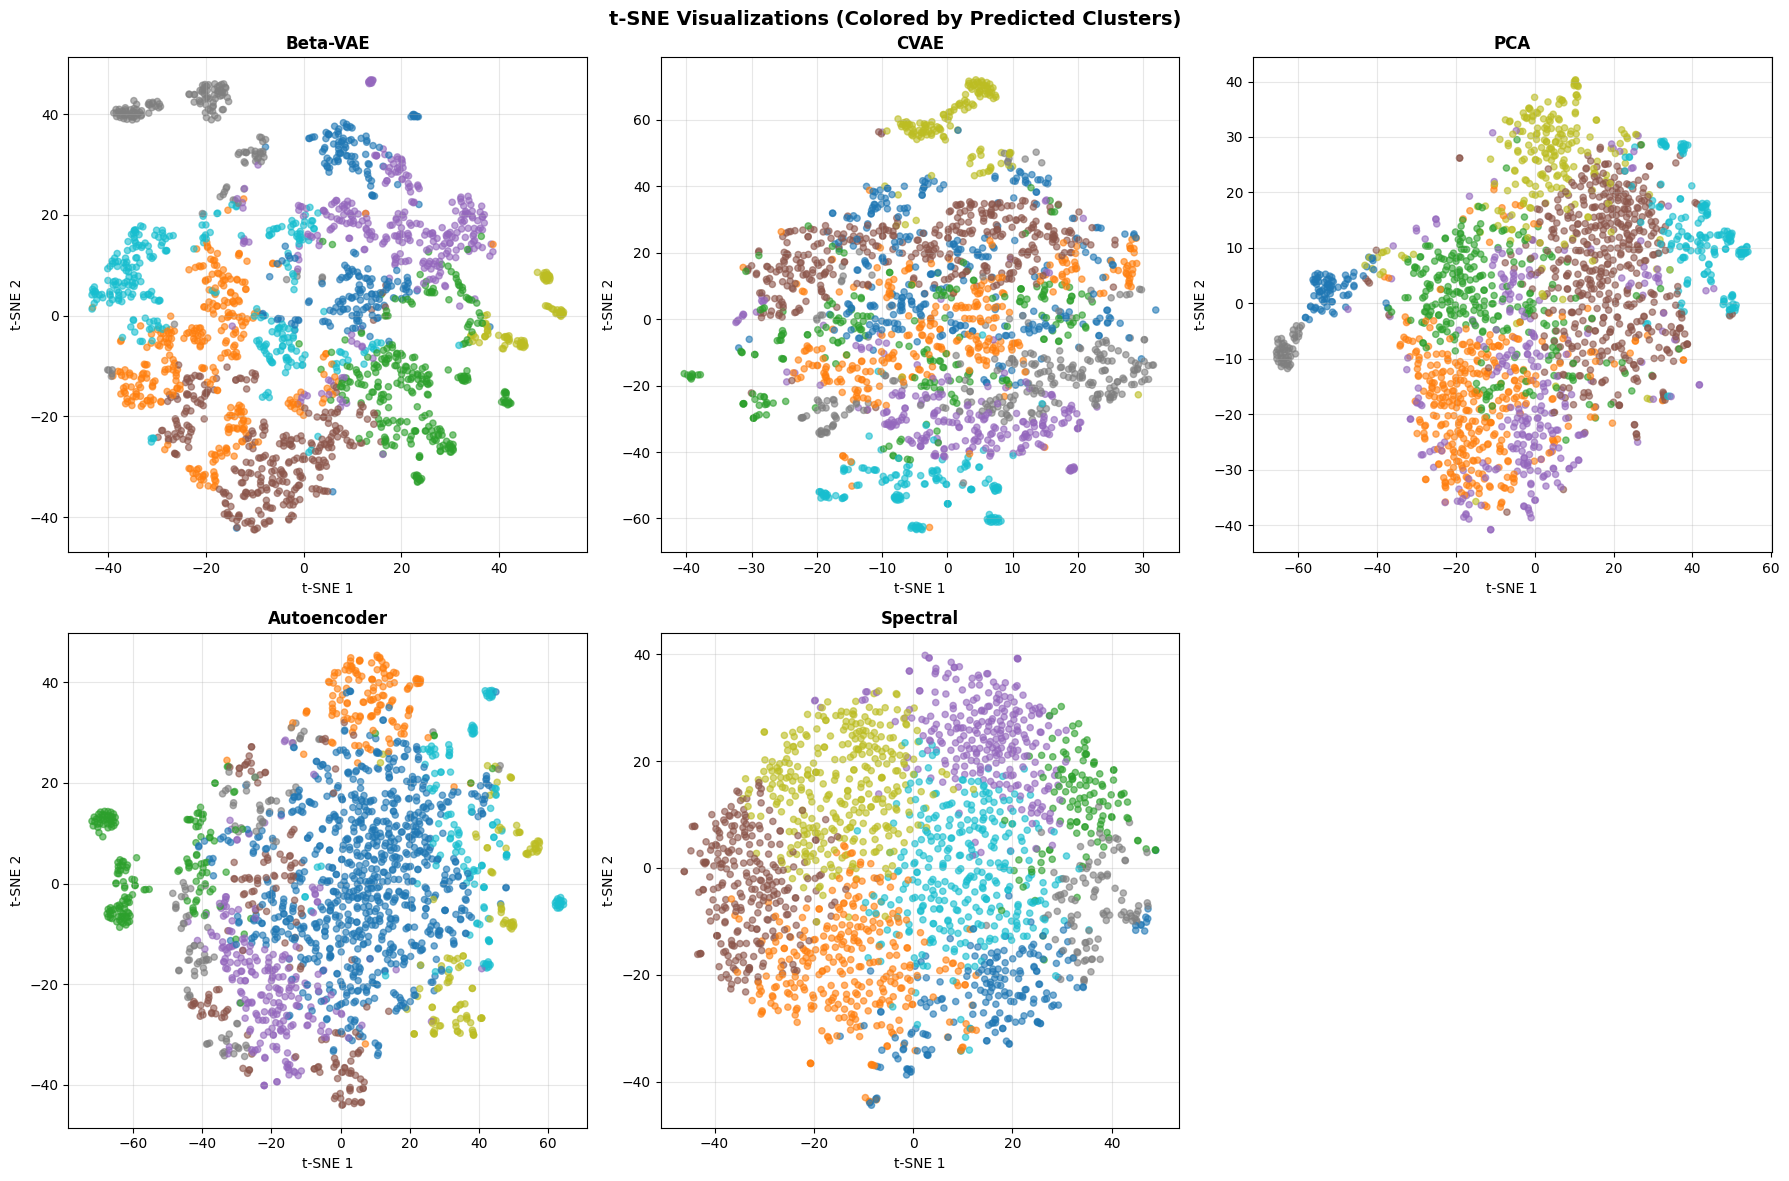

In [ ]:
# Cell 27: t-SNE with Predicted Clusters
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (feature_name, projection) in enumerate(tsne_projections.items()):
    if idx < len(axes):
        # Use K-Means labels
        labels = all_clustering_results[feature_name]['kmeans']

        scatter = axes[idx].scatter(
            projection[:, 0],
            projection[:, 1],
            c=labels,
            cmap='tab10',
            s=20,
            alpha=0.6
        )
        axes[idx].set_title(f'{feature_name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('t-SNE 1')
        axes[idx].set_ylabel('t-SNE 2')
        axes[idx].grid(alpha=0.3)

if len(feature_sets) < len(axes):
    axes[-1].axis('off')

plt.suptitle('t-SNE Visualizations (Colored by Predicted Clusters)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cse425 datasets/hard_task_tsne_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 28: Analyze Cluster Distribution Over Genres
print("=" * 80)
print("CLUSTER DISTRIBUTION OVER GENRES")
print("=" * 80)

# Get best performing method
best_idx = results_df['Silhouette'].idxmax()
best_config = results_df.iloc[best_idx]
best_feature = best_config['Feature Type']
best_method = best_config['Method'].lower()

print(f"Best configuration: {best_feature} + {best_method.upper()}")
print(f"Silhouette Score: {best_config['Silhouette']:.4f}")
print(f"NMI: {best_config['NMI']:.4f}")
print(f"ARI: {best_config['ARI']:.4f}")
print()

# Get labels
best_labels = all_clustering_results[best_feature][best_method]

# Create confusion-like matrix: cluster vs genre
cluster_genre_matrix = pd.crosstab(
    best_labels,
    [label_encoder.inverse_transform([g])[0] for g in genre_labels],
    rownames=['Cluster'],
    colnames=['Genre']
)

print("Cluster-Genre Distribution Matrix:")
print(cluster_genre_matrix)

CLUSTER DISTRIBUTION OVER GENRES
Best configuration: Beta-VAE + KMEANS
Silhouette Score: 0.1861
NMI: 0.0053
ARI: -0.0006

Cluster-Genre Distribution Matrix:
Genre    Electronic  Experimental  Folk  Hip-Hop  Instrumental  International  \
Cluster                                                                         
0                28            27    30       32            10             26   
1                39            35    49       43            20             44   
2                30            27    42       47            18             36   
3                42            29    40       34            16             40   
4                48            30    37       58            17             37   
5                17            14    21       22             9             17   
6                 9             4    11       10             3              7   
7                35            30    53       39            19             33   

Genre    Pop  Rock  
Cluster    

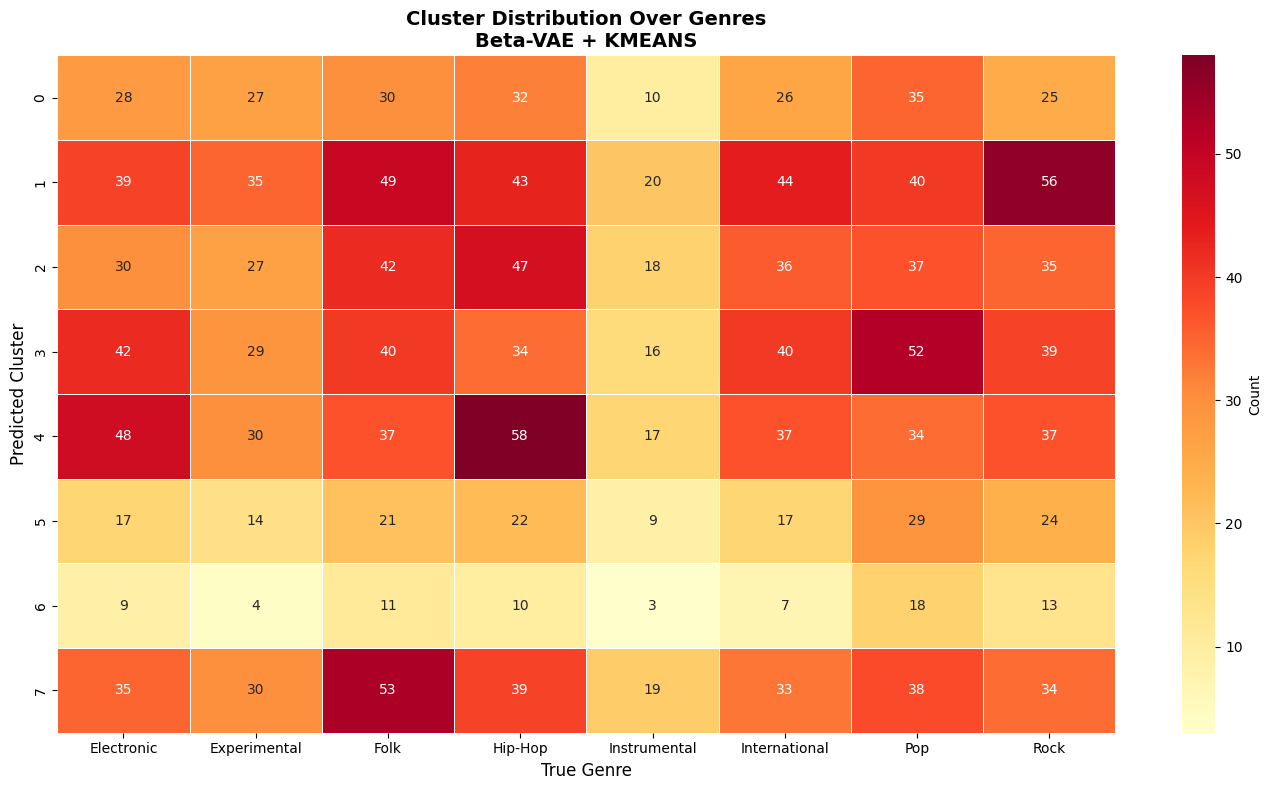

In [ ]:
# Cell 29: Visualize Cluster-Genre Distribution
plt.figure(figsize=(14, 8))

sns.heatmap(
    cluster_genre_matrix,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    cbar_kws={'label': 'Count'},
    linewidths=0.5
)

plt.title(f'Cluster Distribution Over Genres\n{best_feature} + {best_method.upper()}',
          fontsize=14, fontweight='bold')
plt.xlabel('True Genre', fontsize=12)
plt.ylabel('Predicted Cluster', fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cse425 datasets/cluster_genre_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

GENERATING RECONSTRUCTION EXAMPLES
Reconstruction Quality:
--------------------------------------------------
Sample 1 (Genre: Hip-Hop):
  Beta-VAE MSE: 0.682296
  CVAE MSE: 0.571856
Sample 2 (Genre: International):
  Beta-VAE MSE: 0.747799
  CVAE MSE: 0.642442
Sample 3 (Genre: Electronic):
  Beta-VAE MSE: 0.916217
  CVAE MSE: 0.729083
Sample 4 (Genre: Experimental):
  Beta-VAE MSE: 0.848802
  CVAE MSE: 0.736599
Sample 5 (Genre: Pop):
  Beta-VAE MSE: 0.953490
  CVAE MSE: 0.711338


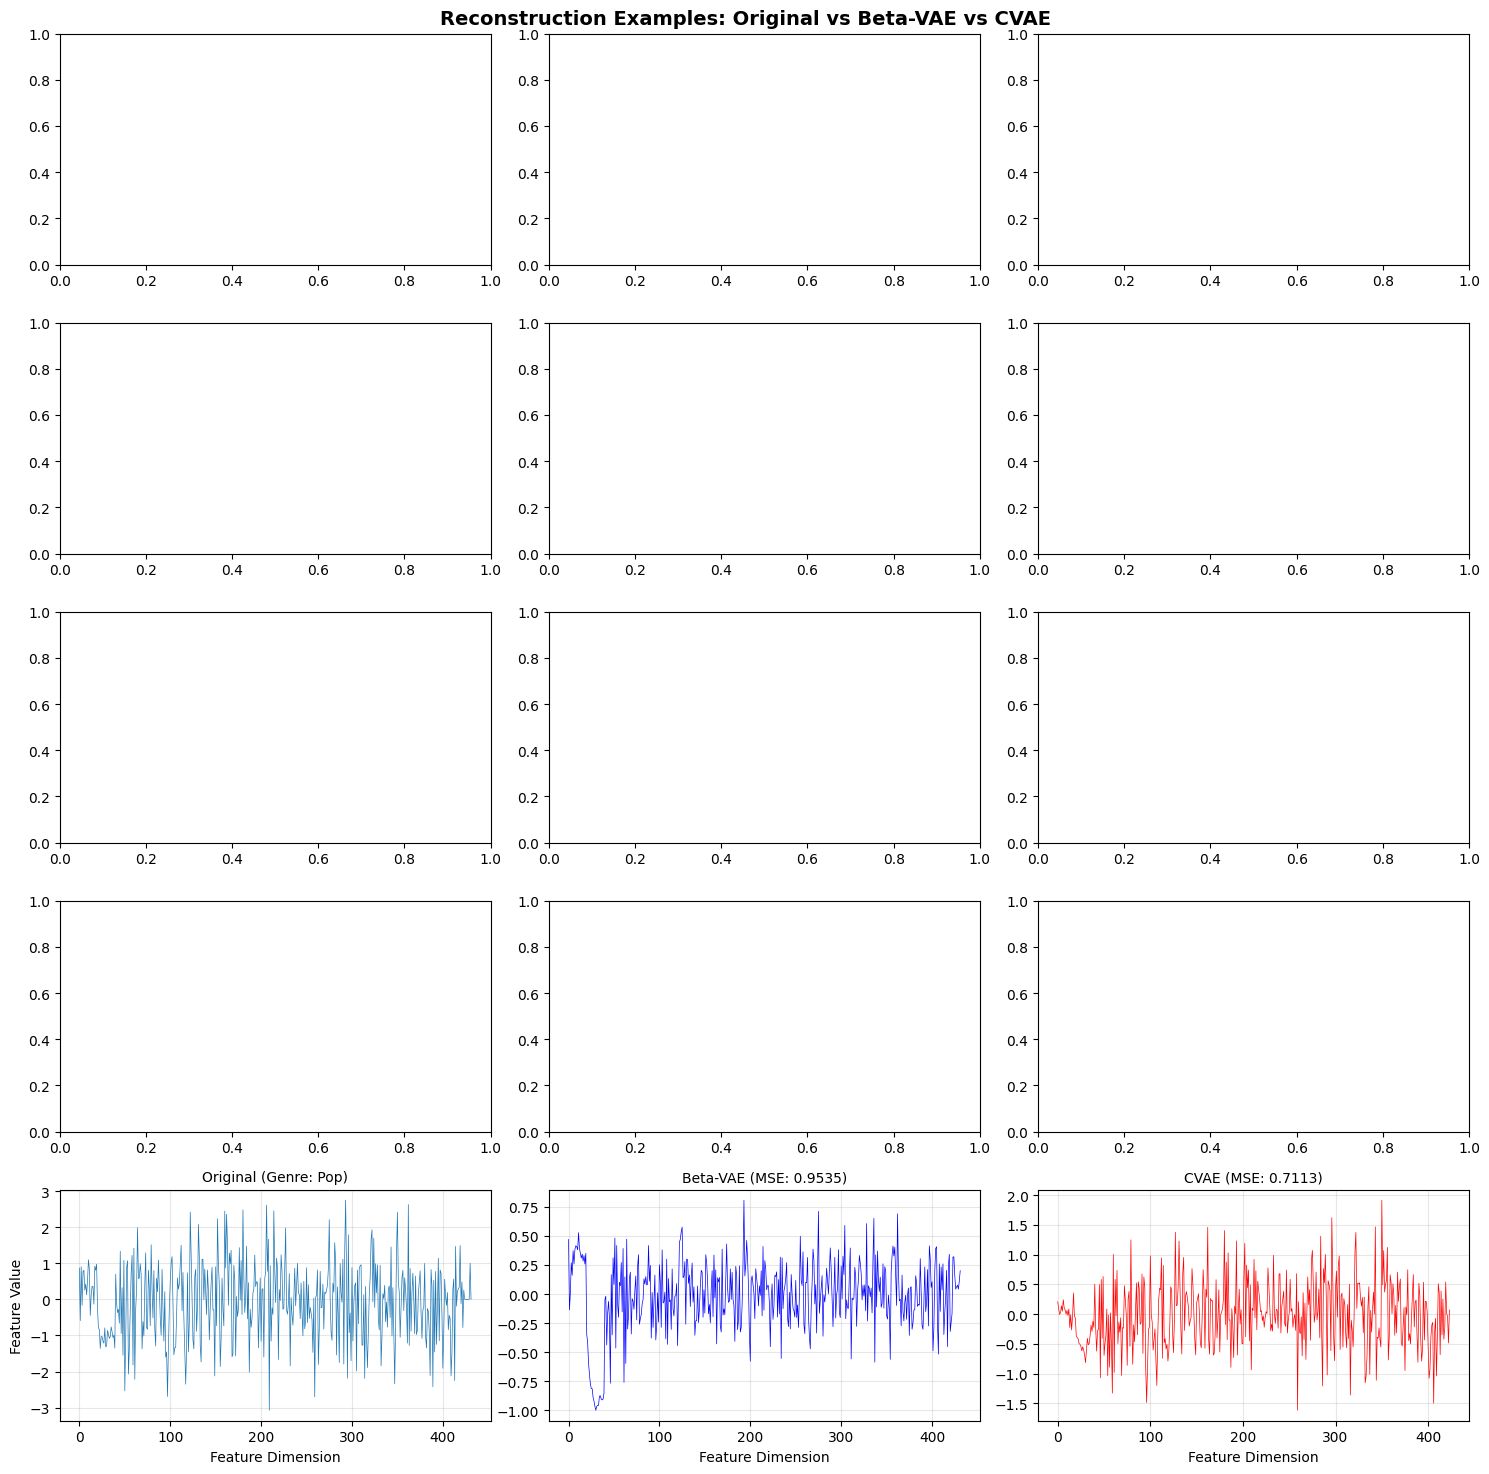

In [ ]:
# Cell 30: Generate Reconstruction Examples from VAE
print("=" * 80)
print("GENERATING RECONSTRUCTION EXAMPLES")
print("=" * 80)

# Select random samples
n_samples = 5
sample_indices = np.random.choice(len(X_multimodal), n_samples, replace=False)

# Get samples
samples = torch.FloatTensor(X_multimodal[sample_indices]).to(device)

# Beta-VAE reconstructions
beta_vae.eval()
with torch.no_grad():
    recon_beta, mu_beta, _ = beta_vae(samples)
    recon_beta = recon_beta.cpu().numpy()

# CVAE reconstructions
sample_conditions = torch.FloatTensor(genre_onehot[sample_indices]).to(device)
cvae.eval()
with torch.no_grad():
    recon_cvae, mu_cvae, _ = cvae(samples[:, :X_audio_lyrics.shape[1]], sample_conditions)
    recon_cvae = recon_cvae.cpu().numpy()

original_samples = X_multimodal[sample_indices]

# Calculate reconstruction errors
mse_beta = np.mean((original_samples - recon_beta)**2, axis=1)
mse_cvae = np.mean((original_samples[:, :X_audio_lyrics.shape[1]] - recon_cvae)**2, axis=1)

print("Reconstruction Quality:")
print("-" * 50)
for i in range(n_samples):
    genre_name = label_encoder.inverse_transform([genre_labels[sample_indices[i]]])[0]
    print(f"Sample {i+1} (Genre: {genre_name}):")
    print(f"  Beta-VAE MSE: {mse_beta[i]:.6f}")
    print(f"  CVAE MSE: {mse_cvae[i]:.6f}")
fig, axes = plt.subplots(n_samples, 3, figsize=(15, n_samples*3))
for i in range(n_samples):
    genre_name = label_encoder.inverse_transform([genre_labels[sample_indices[i]]])[0]
# Original
axes[i, 0].plot(original_samples[i], linewidth=0.5)
axes[i, 0].set_title(f'Original (Genre: {genre_name})', fontsize=10)
axes[i, 0].set_ylabel('Feature Value')
axes[i, 0].grid(alpha=0.3)

# Beta-VAE
axes[i, 1].plot(recon_beta[i], linewidth=0.5, color='blue')
axes[i, 1].set_title(f'Beta-VAE (MSE: {mse_beta[i]:.4f})', fontsize=10)
axes[i, 1].grid(alpha=0.3)

# CVAE
axes[i, 2].plot(recon_cvae[i], linewidth=0.5, color='red')
axes[i, 2].set_title(f'CVAE (MSE: {mse_cvae[i]:.4f})', fontsize=10)
axes[i, 2].grid(alpha=0.3)

if i == n_samples - 1:
    axes[i, 0].set_xlabel('Feature Dimension')
    axes[i, 1].set_xlabel('Feature Dimension')
    axes[i, 2].set_xlabel('Feature Dimension')
plt.suptitle('Reconstruction Examples: Original vs Beta-VAE vs CVAE', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cse425 datasets/reconstruction_examples.png', dpi=300, bbox_inches='tight')
plt.show()

LATENT SPACE DISENTANGLEMENT ANALYSIS
Latent Space Statistics:
  Mean of μ: -0.004719
  Std of μ: 0.374981
  Active dimensions: 5/32 (15.6%)



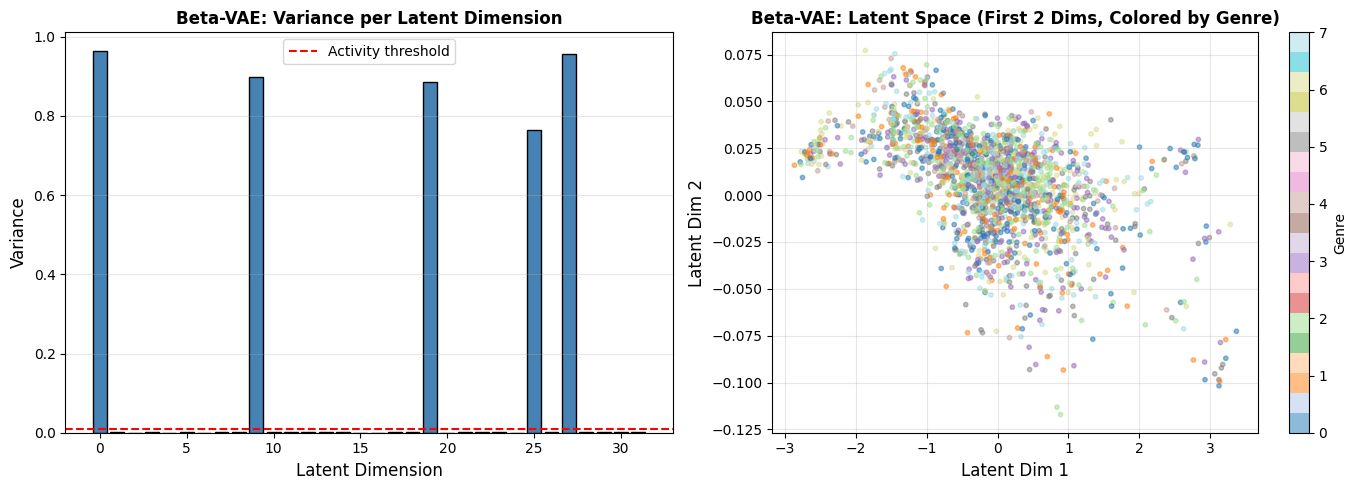

In [ ]:
# Cell 31: Analyze Latent Space Disentanglement (Beta-VAE)
print("=" * 80)
print("LATENT SPACE DISENTANGLEMENT ANALYSIS")
print("=" * 80)

# Extract all latent representations
beta_vae.eval()
all_mu_beta = []
all_logvar_beta = []

with torch.no_grad():
    for data in dataloader_multimodal:
        data = data.to(device)
        mu, logvar = beta_vae.encode(data)
        all_mu_beta.append(mu.cpu().numpy())
        all_logvar_beta.append(logvar.cpu().numpy())

all_mu_beta = np.vstack(all_mu_beta)
all_logvar_beta = np.vstack(all_logvar_beta)

# Calculate variance per dimension
latent_variance = np.var(all_mu_beta, axis=0)
active_dims = np.sum(latent_variance > 0.01)

print(f"Latent Space Statistics:")
print(f"  Mean of μ: {all_mu_beta.mean():.6f}")
print(f"  Std of μ: {all_mu_beta.std():.6f}")
print(f"  Active dimensions: {active_dims}/{latent_dim} ({active_dims/latent_dim*100:.1f}%)")
print()

# Visualize latent dimension activity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Variance per dimension
axes[0].bar(range(latent_dim), latent_variance, color='steelblue', edgecolor='black')
axes[0].axhline(y=0.01, color='r', linestyle='--', label='Activity threshold')
axes[0].set_xlabel('Latent Dimension', fontsize=12)
axes[0].set_ylabel('Variance', fontsize=12)
axes[0].set_title('Beta-VAE: Variance per Latent Dimension', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Latent space distribution (first 2 dims)
scatter = axes[1].scatter(all_mu_beta[:, 0], all_mu_beta[:, 1],
                          c=genre_labels, cmap='tab20', s=10, alpha=0.5)
axes[1].set_xlabel('Latent Dim 1', fontsize=12)
axes[1].set_ylabel('Latent Dim 2', fontsize=12)
axes[1].set_title('Beta-VAE: Latent Space (First 2 Dims, Colored by Genre)',
                  fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Genre')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cse425 datasets/latent_space_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

LATENT DIMENSION - GENRE CORRELATION
Dimensions significantly correlated with genre (p < 0.05): 7

Top 10 most genre-correlated dimensions:
 Dimension  F-statistic  p-value  Significant
        31     2.801934 0.006657         True
        11     2.652375 0.009903         True
         1     2.410536 0.018585         True
        17     2.402644 0.018965         True
        13     2.289894 0.025272         True
        25     2.166655 0.034414         True
        12     2.160887 0.034911         True


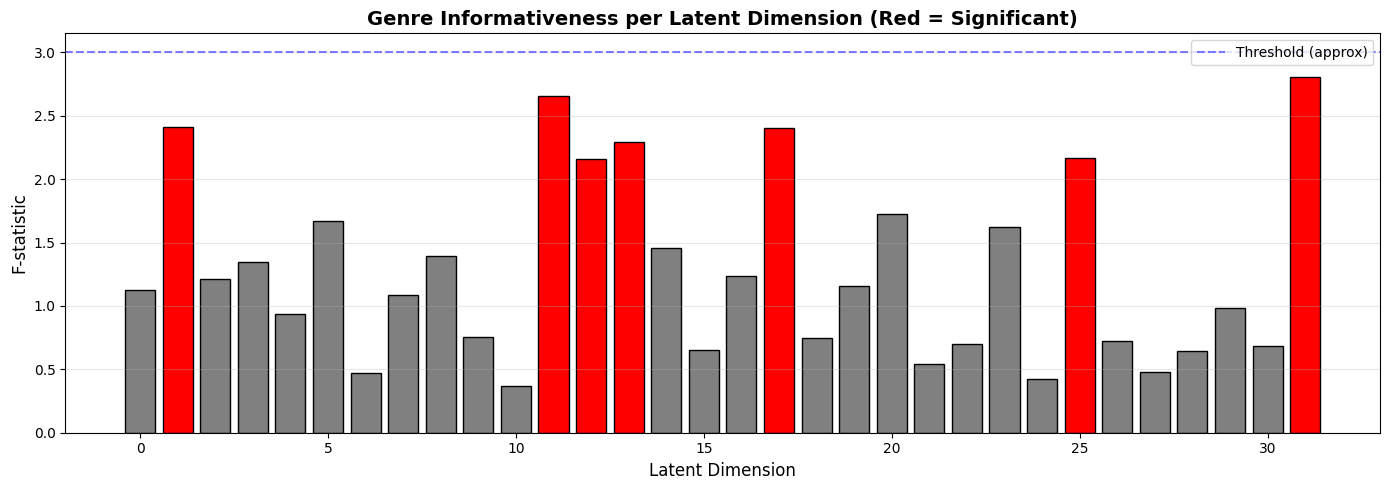

In [ ]:
# Cell 32: Correlation Between Latent Dimensions and Genres
print("=" * 80)
print("LATENT DIMENSION - GENRE CORRELATION")
print("=" * 80)

# Calculate correlation between each latent dimension and genre
from scipy.stats import f_oneway

# Perform ANOVA to find which latent dimensions correlate with genre
dimension_genre_scores = []

for dim in range(latent_dim):
    # Group latent values by genre
    groups = [all_mu_beta[genre_labels == g, dim] for g in range(n_genres)]

    # ANOVA test
    f_stat, p_value = f_oneway(*groups)

    dimension_genre_scores.append({
        'Dimension': dim,
        'F-statistic': f_stat,
        'p-value': p_value,
        'Significant': p_value < 0.05
    })

dim_genre_df = pd.DataFrame(dimension_genre_scores)
significant_dims = dim_genre_df[dim_genre_df['Significant']].sort_values('F-statistic', ascending=False)

print(f"Dimensions significantly correlated with genre (p < 0.05): {len(significant_dims)}")
print()
print("Top 10 most genre-correlated dimensions:")
print(significant_dims.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(14, 5))
colors = ['red' if p < 0.05 else 'gray' for p in dim_genre_df['p-value']]
plt.bar(dim_genre_df['Dimension'], dim_genre_df['F-statistic'], color=colors, edgecolor='black')
plt.axhline(y=3.0, color='blue', linestyle='--', alpha=0.5, label='Threshold (approx)')
plt.xlabel('Latent Dimension', fontsize=12)
plt.ylabel('F-statistic', fontsize=12)
plt.title('Genre Informativeness per Latent Dimension (Red = Significant)',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cse425 datasets/latent_genre_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 33: Save All Models and Results
print("=" * 80)
print("SAVING MODELS AND RESULTS")
print("=" * 80)

# Save models
torch.save(beta_vae.state_dict(), '/content/drive/MyDrive/cse425 datasets/beta_vae_model.pth')
torch.save(cvae.state_dict(), '/content/drive/MyDrive/cse425 datasets/cvae_model.pth')
torch.save(autoencoder.state_dict(), '/content/drive/MyDrive/cse425 datasets/autoencoder_model.pth')

print(" Models saved")

# Save all results
hard_task_results = {
    'latent_features': {
        'beta_vae': Z_beta_vae,
        'cvae': Z_cvae,
        'pca': Z_pca_multimodal,
        'autoencoder': Z_autoencoder,
        'spectral': Z_spectral
    },
    'clustering_results': all_clustering_results,
    'evaluation_metrics': results_df,
    'tsne_projections': tsne_projections,
    'genre_labels': genre_labels,
    'genre_names': label_encoder.classes_,
    'matched_files': matched_files,
    'best_configuration': {
        'feature_type': best_config['Feature Type'],
        'method': best_config['Method'],
        'silhouette': best_config['Silhouette'],
        'nmi': best_config['NMI'],
        'ari': best_config['ARI'],
        'purity': best_config['Purity']
    },
    'hyperparameters': {
        'latent_dim': latent_dim,
        'beta_value': beta_value,
        'n_genres': n_genres,
        'num_epochs': num_epochs,
        'batch_size': batch_size
    },
    'training_history': {
        'beta_vae_losses': train_losses_beta,
        'cvae_losses': train_losses_cvae,
        'beta_vae_recon': recon_losses_beta,
        'cvae_recon': recon_losses_cvae
    }
}

# Save to pickle
results_path = '/content/drive/MyDrive/cse425 datasets/hard_task_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(hard_task_results, f)

print(" Results saved to pickle")

# Save latent space analysis
latent_analysis = {
    'latent_variance': latent_variance,
    'active_dimensions': active_dims,
    'dimension_genre_correlation': dim_genre_df
}

with open('/content/drive/MyDrive/cse425 datasets/latent_space_analysis.pkl', 'wb') as f:
    pickle.dump(latent_analysis, f)

print(" Latent space analysis saved")

print()
print("All files saved:")
print("  1. beta_vae_model.pth")
print("  2. cvae_model.pth")
print("  3. autoencoder_model.pth")
print("  4. hard_task_results.pkl")
print("  5. hard_task_metrics.csv")
print("  6. latent_space_analysis.pkl")
print("  7. Multiple visualization PNG files")

SAVING MODELS AND RESULTS
 Models saved
 Results saved to pickle
 Latent space analysis saved

All files saved:
  1. beta_vae_model.pth
  2. cvae_model.pth
  3. autoencoder_model.pth
  4. hard_task_results.pkl
  5. hard_task_metrics.csv
  6. latent_space_analysis.pkl
  7. Multiple visualization PNG files


In [ ]:
# Cell 34: Generate Final Summary Report
print("=" * 80)
print("HARD TASK - COMPREHENSIVE SUMMARY REPORT")
print("=" * 80)
print()

print(" DATASET INFORMATION:")
print("-" * 80)
print(f"Total samples: {len(matched_files)}")
print(f"Folders used: 050-096")
print(f"Audio feature dimension: {X_audio_normalized.shape[1]}")
print(f"Lyrics embedding dimension: {X_lyrics_normalized.shape[1]}")
print(f"Genre categories: {n_genres}")
print(f"Genre distribution:")
for genre, count in zip(*np.unique(matched_genres, return_counts=True)):
    print(f"  - {genre}: {count} samples")
print()

print(" MODEL ARCHITECTURES:")
print("-" * 80)
print(f"1. Beta-VAE (β={beta_value}):")
print(f"   - Input: {X_multimodal.shape[1]} (audio + lyrics + genre)")
print(f"   - Latent: {latent_dim}")
print(f"   - Parameters: {sum(p.numel() for p in beta_vae.parameters()):,}")
print()
print(f"2. Conditional VAE:")
print(f"   - Input: {X_audio_lyrics.shape[1]} (audio + lyrics)")
print(f"   - Condition: {n_genres} (genre one-hot)")
print(f"   - Latent: {latent_dim}")
print(f"   - Parameters: {sum(p.numel() for p in cvae.parameters()):,}")
print()

print(" FEATURE REPRESENTATIONS:")
print("-" * 80)
print(f"1. Beta-VAE latent features")
print(f"2. Conditional VAE latent features")
print(f"3. PCA baseline (linear)")
print(f"4. Standard Autoencoder")
print(f"5. Direct spectral features (MFCC)")
print()

print(" CLUSTERING METHODS:")
print("-" * 80)
print(f"1. K-Means (k={n_genres})")
print(f"2. Agglomerative Clustering (k={n_genres})")
print()

print(" EVALUATION METRICS:")
print("-" * 80)
print(f"1. Silhouette Score (clustering quality)")
print(f"2. Davies-Bouldin Index (cluster separation)")
print(f"3. Calinski-Harabasz Index (cluster variance ratio)")
print(f"4. Normalized Mutual Information (label agreement)")
print(f"5. Adjusted Rand Index (label similarity)")
print(f"6. Cluster Purity (dominant class fraction)")
print()

print(" BEST PERFORMING CONFIGURATION:")
print("-" * 80)
print(f"Feature Type: {best_config['Feature Type']}")
print(f"Clustering Method: {best_config['Method']}")
print(f"Silhouette Score: {best_config['Silhouette']:.4f}")
print(f"Davies-Bouldin Index: {best_config['Davies-Bouldin']:.4f}")
print(f"Calinski-Harabasz: {best_config['Calinski-Harabasz']:.2f}")
print(f"NMI: {best_config['NMI']:.4f}")
print(f"ARI: {best_config['ARI']:.4f}")
print(f"Cluster Purity: {best_config['Purity']:.4f}")
print()

print(" COMPLETE RESULTS TABLE:")
print("-" * 80)
print(results_df.to_string(index=False))
print()

print(" KEY FINDINGS:")
print("-" * 80)

# Compare Beta-VAE vs CVAE
beta_avg_sil = results_df[results_df['Feature Type'] == 'Beta-VAE']['Silhouette'].mean()
cvae_avg_sil = results_df[results_df['Feature Type'] == 'CVAE']['Silhouette'].mean()
pca_avg_sil = results_df[results_df['Feature Type'] == 'PCA']['Silhouette'].mean()

print(f"1. Beta-VAE vs CVAE:")
if beta_avg_sil > cvae_avg_sil:
    print(f"    Beta-VAE performs better (Avg Silhouette: {beta_avg_sil:.4f} vs {cvae_avg_sil:.4f})")
    print(f"    Disentangled representations aid clustering")
else:
    print(f"    CVAE performs better (Avg Silhouette: {cvae_avg_sil:.4f} vs {beta_avg_sil:.4f})")
    print(f"    Conditional information from genre helps learning")

print()
print(f"2. Deep Learning vs PCA:")
if max(beta_avg_sil, cvae_avg_sil) > pca_avg_sil:
    print(f"    Deep models outperform PCA")
    print(f"    Non-linear VAE captures complex patterns in multi-modal data")
else:
    print(f"   PCA competitive with deep models")
    print(f"   Multi-modal features may still have strong linear structure")

print()
print(f"3. Label-Based Metrics (NMI & ARI):")
best_nmi = results_df['NMI'].max()
best_ari = results_df['ARI'].max()
print(f"   Best NMI: {best_nmi:.4f}")
print(f"   Best ARI: {best_ari:.4f}")
if best_nmi > 0.3 or best_ari > 0.3:
    print(f"   Moderate to good alignment with genre labels")
else:
    print(f"   Low alignment suggests clusters don't follow genre boundaries")
    print(f"   Clusters may represent other music characteristics")

print()
print(f"4. Disentanglement:")
print(f"   Active latent dimensions: {active_dims}/{latent_dim} ({active_dims/latent_dim*100:.1f}%)")
if active_dims > latent_dim * 0.7:
    print(f"    Good latent space utilization")
else:
    print(f"    Some posterior collapse detected")

print()
print("=" * 80)
print(" HARD TASK COMPLETED SUCCESSFULLY!")
print("=" * 80)

HARD TASK - COMPREHENSIVE SUMMARY REPORT

 DATASET INFORMATION:
--------------------------------------------------------------------------------
Total samples: 1910
Folders used: 050-096
Audio feature dimension: 40
Lyrics embedding dimension: 384
Genre categories: 8
Genre distribution:
  - Electronic: 248 samples
  - Experimental: 196 samples
  - Folk: 283 samples
  - Hip-Hop: 285 samples
  - Instrumental: 112 samples
  - International: 240 samples
  - Pop: 283 samples
  - Rock: 263 samples

 MODEL ARCHITECTURES:
--------------------------------------------------------------------------------
1. Beta-VAE (β=4.0):
   - Input: 432 (audio + lyrics + genre)
   - Latent: 32
   - Parameters: 788,208

2. Conditional VAE:
   - Input: 424 (audio + lyrics)
   - Condition: 8 (genre one-hot)
   - Latent: 32
   - Parameters: 785,128

 FEATURE REPRESENTATIONS:
--------------------------------------------------------------------------------
1. Beta-VAE latent features
2. Conditional VAE latent featur